In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
from IPython.core.debugger import Tracer
import scipy as sp
from scipy.linalg import svd
import scipy.linalg
from sklearn.decomposition import PCA
%matplotlib inline

import os
import _pickle as pkl

from dateutil.parser import parse


In [2]:
def get_symbol(symbol, data_loc, start_date=None, end_date=None):
    pickle_file = data_loc+symbol+'.pkl'
    if os.path.isfile(pickle_file):
#         print("Reading", symbol, "from pickle")
        df = pd.read_pickle(pickle_file)
    else:
        try:
            df = pd.read_csv(
                data_loc+symbol+'.txt', dtype={'Time': object}
            )
        except:
            print("failed to read in ",symbol)
            return None
    if not os.path.isfile(pickle_file):
        df['timestamp'] = pd.to_datetime(
            df['Date']+" "+ df['Time'], format="%m/%d/%Y %H%M"
        )
        df.set_index('timestamp', drop=False, inplace=True)
        df.drop(['Date', 'Time'], axis=1, inplace=True)
        pkl.dump(df, open(pickle_file, 'wb'), protocol=2)
#         print("Dumped ", symbol, " to pickle")
    
    if start_date and end_date:
        return df[( (df['timestamp'] >= pd.to_datetime(start_date)) \
                  & (df['timestamp'] <= pd.to_datetime(end_date)))]
    else:
        return df
    
def df_to_returns(df, price='Close'): # or log returns
    prices = df[price]
    prices_shifted = np.roll(prices, -1)
    rets_ = (prices_shifted - prices) / prices_shifted
    return rets_[:len(rets_) - 1]
#     log_rets = np.log(1 + (prices_shifted-prices  / prices_shifted))
#     return log_rets[:len(log_rets)-1]

def df_to_standard_returns(df, price='Close'): # or log returns
    rets_ = df_to_returns(df, price)
    standard_ = (rets_ - rets_.mean()) / rets_.std()
    return standard_[:]

def get_symbols_matrix(symbols, data_loc, start_date, end_date, price='Close'):
    df = pd.DataFrame(columns=symbols) 
    real_syms = []
    for s in symbols:
        sym = get_symbol(s, data_loc, start_date, end_date)
        is_full, bad_days = check_integrity(sym)
        if (is_full):
            df[s] = df_to_standard_returns(sym)
            real_syms.append(sym)
        else:
            df.drop(s, axis=1, inplace=True)
            print(s, "failed integrity check")
    df.fillna(method='ffill', axis=1, inplace=True)
    return df, real_syms

def check_integrity(sym):
    # A good way to check for full data in a trading day
    bad_data = sym.groupby(sym.timestamp.dt.date).count() > 195
    bad_days = bad_data.Close
    is_full = bad_days.all()
    return is_full, bad_days


In [5]:
data_loc = "C:/Users/Ian/Desktop/Stock Data/DJI/"
stock_symbols = []
for stockSymbol in os.listdir(data_loc):
    if stockSymbol.endswith(".txt"):
        symbol = os.path.splitext(stockSymbol)[0]
        stock_symbols.append(symbol)

sym_mat, real_syms = get_symbols_matrix(stock_symbols, data_loc, start_date="12/01/2013", end_date="12/31/2013")

corr = sym_mat.corr()

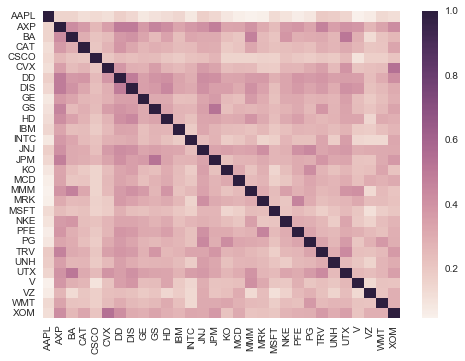

In [16]:
import seaborn as sns

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.savefig("corr_heat_map.png")

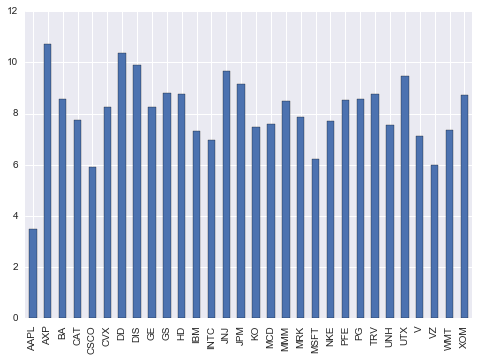

In [31]:
corr_sum = corr.sum(axis=1) - 1
corr_sum.plot.bar()
plt.savefig('sum_of_corr.png')
plt.show()

In [84]:
sig_corr = corr[(corr.sum(axis=1) - 1 > 9.69)]

In [85]:
sig_stocks = sym_mat[['AXP', 'DD', 'DIS']]
csvfile = "C:/Users/Ian/Desktop/sigstocks.csv"
sig_stocks.to_csv(csvfile)

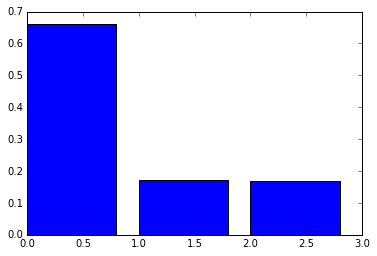

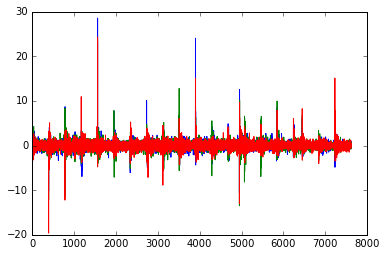

In [92]:
sigPCA=PCA(svd_solver='randomized')
sigPCA.fit(sig_stocks)
plt.bar(np.arange(len(sigPCA.explained_variance_ratio_)), sigPCA.explained_variance_ratio_)
plt.show()
plt.plot(sig_stocks.values)
plt.show()

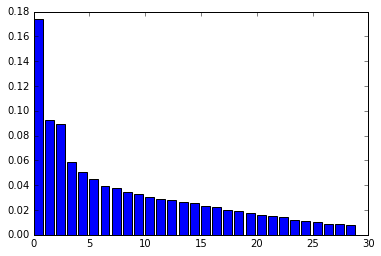

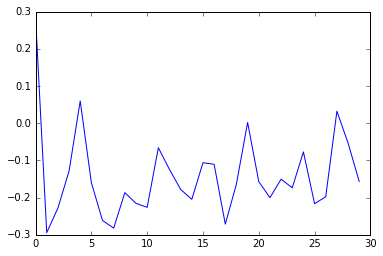

In [82]:
pca = PCA(svd_solver = 'randomized')
pca.fit_transform(corr)

# fig, axes = plt.subplots(nrows=2, ncols=2)
# axes[0,0].plot(pca.explained_variance_)
# axes[1,0].plot(pca.explained_variance_ratio_)
plt.bar(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.show()
plt.savefig('explained_var.png')
plt.plot(pca.components_[0,:])

In [38]:
train_start_date = "12/01/2013"
train_end_date = "12/25/2013"

test_start_date = "12/26/2013"
test_end_date = "12/31/2013"

dia_y_train = get_symbol("DIA", "C:/Users/Ian/Desktop/Stock Data/ETFs/", 
                       train_start_date, train_end_date)

dia_y_test = get_symbol("DIA", "C:/Users/Ian/Desktop/Stock Data/ETFs/", 
                       test_start_date, test_end_date)


In [56]:
data_loc = "C:/Users/Ian/Desktop/Stock Data/DJI/"
stock_symbols = []
for stockSymbol in os.listdir(data_loc):
    if stockSymbol.endswith(".txt"):
        symbol = os.path.splitext(stockSymbol)[0]
        stock_symbols.append(symbol)

dia_X_train, real_syms = get_symbols_matrix(stock_symbols, data_loc,
                                            train_start_date, train_end_date)

dia_X_test, real_syms = get_symbols_matrix(stock_symbols, data_loc, 
                                           test_start_date, test_end_date)


In [94]:
diaPCA = PCA(svd_solver = 'randomized')
train_corr = dia_X_train.corr()
test_corr = dia_X_test.corr()

y_train = dia_y_train['Close'].reshape(-1,1)
X_train = diaPCA.fit_transform(train_corr)

y_test = dia_y_test['Close'].reshape(-1,1)
X_test = diaPCA.fit_transform(test_corr)

dia_X_train.shape

(6449, 30)

In [47]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.layouts import column, row
from IPython.display import clear_output
output_notebook()

Loading BokehJS ...

In [48]:
def mu(X, theta):
    return 1.0 / (1.0 + np.exp(-(X @ theta)))

def loglikelihood(X, y, theta, regularization):
    part1 = np.sum( (1-y) * np.log(1 - mu(X, theta) + 1e-9)) + np.sum( y * np.log( mu(X, theta) + 1e-9) )
    part2 = regularization * (np.linalg.norm(theta,2))
    return part1 + part2

def gradient(X, theta, y, regularization):
    return X.T @ ( mu(X, theta) - y) + regularization * theta

def gradient_descent(X, y):
    theta = np.zeros((X_train.shape[1],1))
        
    n_iter = 0
    list_iter = []
    list_theta_norm = []
    list_accuracy = []
    list_precision = []
    list_recall = []
    list_f1 = []
    list_loglikelihood = []
    
    regularization_term = 1000
    while True:                  
        n_iter += 1
        #print("Iteration %d" % n_iter)
        grad = gradient(X, theta, y, regularization_term)
        
        if n_iter > 150 or np.sum( (grad**2) ) < 1e-3:
            break
        
        theta = theta - 1e-9 * grad
        
        y_predicted = (mu(X, theta) >= 0.5)
        
        # accuracy: P(y = 1 | y\hat = 1) + P(y = 0 | y\hat = 0)
        accuracy = np.sum( y_predicted == y ) / len(y)
        
        # precision: P(y = 1 | y\hat = 1)
        precision = np.sum((y_predicted * y)) / np.sum(y_predicted) 
        
        # recall: P(y\hat = 1| y = 1)
        recall = np.sum((y_predicted * y)) / np.sum(y)
        
        # F1-score:
        f1 = 2 * precision * recall / (precision + recall)
        
        # find log-likelihood
        log_likelihood_value = loglikelihood(X, y, theta, regularization_term)
        
        list_iter.append(n_iter)
        list_theta_norm.append((np.sum( (grad**2) / float(len(grad)) )))
        list_accuracy.append(accuracy)
        list_precision.append(precision)
        list_recall.append(recall)
        list_f1.append(f1)
        list_loglikelihood.append(log_likelihood_value)
        
        
        if(n_iter % 25 == 0):
            clear_output()
            #print("Finish iteration %d : accuracy = %f, precision = %f, recall = %f, F1-score= %f" % (n_iter, accuracy, precision, recall, f1))
            current_width = 300 + (n_iter/25)*125
            plot1 = figure(width=int(current_width), height=300, y_axis_type="log")
            plot1.title.text = "Gradient Descent on regularization value = %f" % regularization_term
            plot1.circle(list_iter, list_accuracy, line_width=2, color="red", legend="Accuracy")
            plot1.circle(list_iter, list_precision, line_width=2, color="orange", legend="Precision")
            plot1.line(list_iter, list_recall, line_width=2, color="blue", legend="Recall")
            plot1.line(list_iter, list_f1, line_width=2, color="purple", legend="F1-Score")
            plot1.legend.location = "bottom_right"
            plot1.xaxis.axis_label = "Iteration"
            
            plot2 = figure(width=int(current_width), height=300)
            plot2.title.text = "Gradient Descent on regularization value = %f" % regularization_term
            plot2.line(list_iter, list_loglikelihood, line_width=2, color="purple", legend="Log-likelihood")
            plot2.legend.location = "bottom_right"
            plot2.yaxis.axis_label = "Log-likelihood"
            plot2.xaxis.axis_label = "Iteration"
            show(column(plot1, plot2))
            
    return theta

In [49]:
theta = gradient_descent(X_train, y_train)

ValueError: operands could not be broadcast together with shapes (30,1) (6442,1) 